## 1) Importing Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sms = pd.read_csv('SMSSpamCollection', sep='\t',header=None)
sms.columns = ['tag','sms']
sms.head(10)

,tag,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [2]:
sms.shape

(5572, 2)

In [3]:
sms.tag.value_counts()

ham     4825
spam     747
Name: tag, dtype: int64

https://www.youtube.com/watch?v=lmPfioaW1Tw

## 2)  Text Data Preprocessing and Feature Extraction

In [4]:
# Requires: conda install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anirban.c\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anirban.c\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anirban.c\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
class StemmerTokenizer(object):
    
    def __init__(self):    
        self.stemmer = SnowballStemmer(language='english')
        self.stop = set(stopwords.words('english'))

    def __call__(self, doc):

        # tokenize text into tokens
        tokens = word_tokenize(doc)

        # strip out punctuation
        words = [t for t in tokens if t.isalpha()]
        
        # strip out stopwords
        words = [t for t in words if t not in self.stop]
        
        # lemmatize each token
        return [self.stemmer.stem(t) for t in words]

#### Data Preprocessing & Generating Term-Frequency Inverse Document Frequency Scores for Individual Words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', tokenizer=StemmerTokenizer(), lowercase=True)

sms_tfidf = tfidf.fit_transform(sms.sms)

col_name = tfidf.get_feature_names()
sms_tfidf = pd.DataFrame(sms_tfidf.todense(), columns=col_name)

print(sms_tfidf.shape)

(5572, 5838)


## 3) Predictive Modelling

### 3.1 Logistic Regression

In [8]:
x = sms_tfidf
y = sms['tag']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3900, 5838) (1672, 5838) (3900,) (1672,)


In [9]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression(solver='liblinear',class_weight='balanced',C=3)
lg.fit(x_train,y_train)


LogisticRegression(C=3, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_lg = cross_validate(lg, x_train,y_train, cv=skf, return_train_score=True,return_estimator=False,n_jobs=-1)
scores_lg = pd.DataFrame(scores_lg)
scores_lg

,fit_time,score_time,test_score,train_score
0,0.261567,0.020425,0.966709,0.994550
1,0.251531,0.020425,0.974392,0.994870
2,0.229716,0.012087,0.974359,0.994551
3,0.231736,0.020119,0.975610,0.994233
4,0.251853,0.010048,0.982028,0.994233


In [11]:
print('Mean Test Score of Logistic Regression: ', scores_lg ['test_score'].mean())
print('Mean Train Score of Logistic Regression: ', scores_lg ['train_score'].mean())

Mean Test Score of Logistic Regression:  0.9746196248320675
Mean Train Score of Logistic Regression:  0.9944872406698908


In [12]:
y_pred_lg = lg.predict(x_test)
y_pred_lg

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'lg_Prediction')]

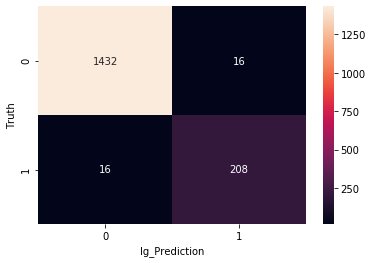

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score, f1_score

ax = sns.heatmap(confusion_matrix(y_test, y_pred_lg), annot=True, fmt='d')
ax.set(xlabel='lg_Prediction', ylabel='Truth')

In [14]:
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.93      0.93      0.93       224

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [15]:
accuracy_score(y_test,y_pred_lg)

0.9808612440191388

In [16]:
lg_features=pd.DataFrame(lg.coef_,columns=x_train.columns)
lg_features=np.transpose(lg_features)
lg_features.columns=['lg_importance']
lg_features.sort_values(by=['lg_importance'],ascending=False).head(40)

,lg_importance
txt,6.886177
stop,5.073520
claim,5.047958
repli,4.943353
servic,4.586059
free,4.470719
mobil,4.433197
text,4.423435
tone,4.233786
call,4.154093


In [17]:
lg_features.sort_values(by=['lg_importance'],ascending=False).tail(10)

,lg_importance
say,-1.917519
da,-1.984590
sir,-2.088117
ü,-2.113926
ok,-2.303759
home,-2.324570
later,-2.559720
sorri,-2.562870
lt,-2.752090
gt,-2.769980


### 3.2 Bagging Classifier

In [18]:
from sklearn.ensemble import BaggingClassifier

num_trees=10
bc = BaggingClassifier(base_estimator = lg, n_estimators = num_trees,n_jobs=-1)
bc.fit(x_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=3,
                                                    class_weight='balanced',
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs

In [19]:
scores_bc = cross_validate(bc, x_train, y_train, cv=skf, return_train_score=True,return_estimator=False,n_jobs=-1)
scores_bc = pd.DataFrame(scores_bc)
scores_bc

,fit_time,score_time,test_score,train_score
0,7.307267,1.121712,0.967990,0.989740
1,6.476113,0.728707,0.976953,0.990702
2,7.720737,1.263570,0.974359,0.990385
3,6.816973,0.569236,0.976893,0.991349
4,8.081976,1.243667,0.979461,0.994553


In [20]:
print('Mean Test Score of Bagging Classifier: ', scores_bc ['test_score'].mean())
print('Mean Train Score of Bagging Classifier: ', scores_bc ['train_score'].mean())

Mean Test Score of Bagging Classifier:  0.9751311312612367
Mean Train Score of Bagging Classifier:  0.9913458038778847


In [21]:
y_pred_bc = bc.predict(x_test)
y_pred_bc

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'bc_Prediction')]

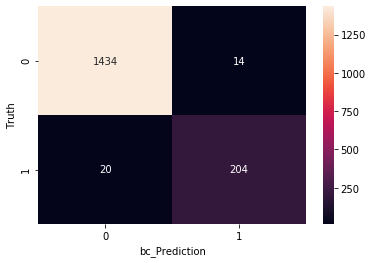

In [22]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_bc), annot=True, fmt='d')
ax.set(xlabel='bc_Prediction', ylabel='Truth')

In [23]:
print(classification_report(y_test, y_pred_bc))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.94      0.91      0.92       224

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [23]:
accuracy_score(y_test,y_pred_bc)

0.9802631578947368

In [24]:
bc_features=pd.DataFrame(bc.estimators_features_,columns=x_train.columns)
bc_features=np.transpose(bc_features)
bc_features.columns=['estimator1','estimator2','estimator3','estimator4','estimator5','estimator6','estimator7','estimator8','estimator9','estimator10']
bc_features.nlargest(20,bc_features.columns)

,estimator1,estimator2,estimator3,estimator4,estimator5,estimator6,estimator7,estimator8,estimator9,estimator10
ü,5837,5837,5837,5837,5837,5837,5837,5837,5837,5837
é,5836,5836,5836,5836,5836,5836,5836,5836,5836,5836
zyada,5835,5835,5835,5835,5835,5835,5835,5835,5835,5835
zouk,5834,5834,5834,5834,5834,5834,5834,5834,5834,5834
zoom,5833,5833,5833,5833,5833,5833,5833,5833,5833,5833
zogtorius,5832,5832,5832,5832,5832,5832,5832,5832,5832,5832
zoe,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831
zindgi,5830,5830,5830,5830,5830,5830,5830,5830,5830,5830
zhong,5829,5829,5829,5829,5829,5829,5829,5829,5829,5829
zero,5828,5828,5828,5828,5828,5828,5828,5828,5828,5828


### 3.3 Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_estimators=30, max_features=0.08,class_weight='balanced_subsample', max_depth=30,
                           n_jobs=-1,oob_score=True)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=30, max_features=0.08,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [26]:
rf.oob_score_

0.9641025641025641

In [27]:
# cross validate Random Forest Classifier
scores_rf = cross_validate(rf, x_train, y_train, cv=skf, return_train_score=True,return_estimator=False,n_jobs=-1)
scores_rf =pd.DataFrame(scores_rf)
scores_rf

,fit_time,score_time,test_score,train_score
0,11.388177,0.917636,0.959027,0.993908
1,12.168673,0.124967,0.966709,0.994229
2,12.515091,0.218697,0.953846,0.993269
3,12.337052,0.209283,0.964056,0.993592
4,12.368322,0.162417,0.969191,0.994873


In [28]:
print('Mean Test Score of RF Classifier: ', scores_rf ['test_score'].mean())
print('Mean Train Score of RF Classifier: ', scores_rf ['train_score'].mean())

Mean Test Score of RF Classifier:  0.9625660285943424
Mean Train Score of RF Classifier:  0.9939743379479467


In [29]:
y_pred_rf = rf.predict(x_test)
y_pred_rf

array(['ham', 'spam', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'RF_Prediction')]

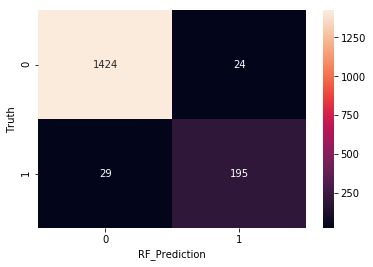

In [30]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
ax.set(xlabel='RF_Prediction', ylabel='Truth')

In [31]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1448
        spam       0.89      0.87      0.88       224

    accuracy                           0.97      1672
   macro avg       0.94      0.93      0.93      1672
weighted avg       0.97      0.97      0.97      1672



In [32]:
accuracy_score(y_test,y_pred_rf)

0.9683014354066986

In [33]:
rf_feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
rf_feature_importances.head(40)

,importance
call,0.099784
free,0.069496
txt,0.064490
text,0.050395
claim,0.039673
repli,0.034936
stop,0.024123
servic,0.023415
win,0.023174
mobil,0.021151


### 3.4 Logistic Regression Using Stochastic Gradient Descent

In [34]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-3, class_weight='balanced', n_jobs=-1,learning_rate='adaptive', eta0=2.5,early_stopping=True).fit(x_train, y_train)
sgd.fit(x_train, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=2.5, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
scores_sgd = cross_validate(sgd, x_train, y_train, cv=skf, return_train_score = True, return_estimator=None,n_jobs=-1)
scores_sgd = pd.DataFrame(scores_sgd)
scores_sgd

,fit_time,score_time,test_score,train_score
0,9.069592,0.023968,0.965429,0.994870
1,8.955702,0.015621,0.974392,0.994550
2,8.955702,0.015621,0.974359,0.994231
3,8.926138,0.019974,0.979461,0.993271
4,8.938484,0.027969,0.978177,0.993271


In [36]:
print('Mean Test Score of SGD Classifier on reduced dataset: ', scores_sgd ['test_score'].mean())
print('Mean Train Score of SGD Classifier on reduced dataset: ', scores_sgd ['train_score'].mean())

Mean Test Score of SGD Classifier on reduced dataset:  0.9743635428858448
Mean Train Score of SGD Classifier on reduced dataset:  0.9940386459558364


In [37]:
y_pred_sgd = sgd.predict(x_test)
y_pred_sgd

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype='<U4')

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'SGD_Prediction')]

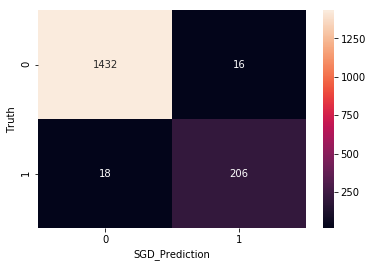

In [38]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_sgd), annot=True, fmt='d')
ax.set(xlabel='SGD_Prediction', ylabel='Truth')

In [39]:
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.93      0.92      0.92       224

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [40]:
sgd_features=pd.DataFrame(sgd.coef_,columns=x_train.columns)
sgd_features=np.transpose(sgd_features)
sgd_features.columns=['sgd_importance']
sgd_features.sort_values(by=['sgd_importance'],ascending=False).head(40)

,sgd_importance
txt,6.744746
claim,5.114755
repli,5.014952
stop,4.942388
free,4.467012
mobil,4.446163
call,4.295339
servic,4.274717
tone,4.239292
text,4.157842


In [41]:
sgd_features.sort_values(by=['sgd_importance'],ascending=False).tail(10)

,sgd_importance
come,-1.839979
da,-1.901815
ü,-1.958502
sir,-2.031125
ok,-2.114070
home,-2.214353
sorri,-2.519936
lt,-2.585295
gt,-2.611349
later,-2.619266


### 3.5 Extreme Gradient Boost Classifier

In [42]:
from xgboost import XGBClassifier 

xgb = XGBClassifier(gamma=0,n_estimators=20, learning_rate=1.15, max_depth=5, seed=8,reg_lambda=0,n_jobs=-1,booster='gbtree')
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=1.15, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=20,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
              seed=8, silent=True, subsample=1)

In [43]:
scores_xgb = cross_validate(xgb, x_train, y_train, cv=skf, return_train_score=True,return_estimator=False,n_jobs=-1)
scores_xgb = pd.DataFrame(scores_xgb)
scores_xgb

,fit_time,score_time,test_score,train_score
0,15.260335,1.131570,0.961588,0.989420
1,14.831265,0.915025,0.971831,0.989099
2,16.400245,0.459387,0.958974,0.988141
3,16.552402,0.442072,0.953787,0.991349
4,14.725013,0.767430,0.965340,0.990067


In [44]:
print('Mean Test Score of XGBoost Classifier: ', scores_xgb ['test_score'].mean())
print('Mean Train Score of XGBoost Classifier: ', scores_xgb ['train_score'].mean())

Mean Test Score of XGBoost Classifier:  0.962304027792827
Mean Train Score of XGBoost Classifier:  0.989615198880978


In [45]:
y_pred_xgb = xgb.predict(x_test)
y_pred_xgb

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'XGB_Prediction')]

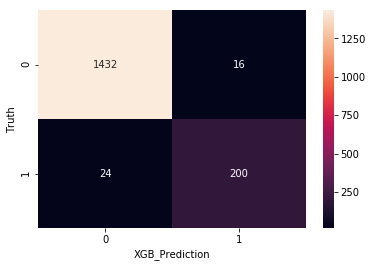

In [46]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
ax.set(xlabel='XGB_Prediction', ylabel='Truth')

In [47]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1448
        spam       0.93      0.89      0.91       224

    accuracy                           0.98      1672
   macro avg       0.95      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [48]:
print('Accuracy Score of XGB Classifier:', accuracy_score(y_pred_xgb, y_test))

Accuracy Score of XGB Classifier: 0.9760765550239234


In [49]:
xgb_feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = x_train.columns,
                                    columns=['xgb_importance']).sort_values('xgb_importance',ascending=False)
xgb_feature_importances.head(40)


,xgb_importance
call,0.047619
send,0.041667
u,0.035714
text,0.029762
hi,0.029762
week,0.023810
txt,0.023810
c,0.023810
stop,0.023810
find,0.023810


## 4. Precision Recall Curves

In [50]:
def precision_recall_curve (model, model_name, pos_label,df):
    
    from sklearn.metrics import precision_recall_curve, auc
    y_pred_proba = model.predict_proba(df)[::,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label=pos_label)
    # calculate precision-recall AUC
    auc = auc(recall, precision)
    
    plt.figure()
    plt.plot(recall, precision, color='darkred', lw=1, label='precision-recall AUC (area = %0.2f)' % auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve of {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.grid(linestyle=':', linewidth=2)
    return plt.show()

<Figure size 864x864 with 0 Axes>

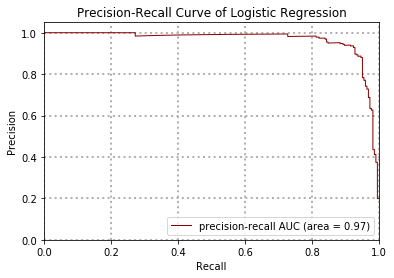

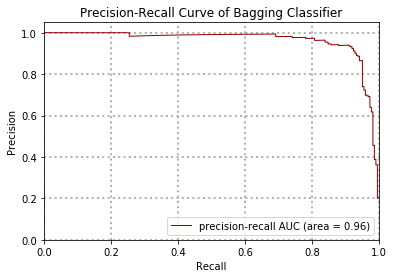

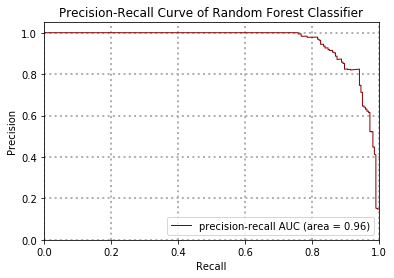

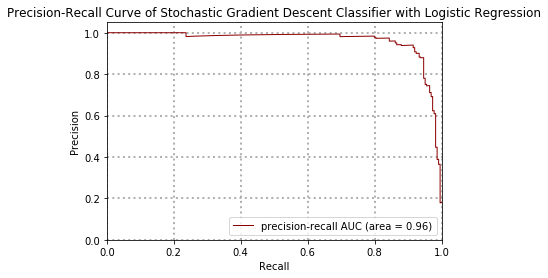

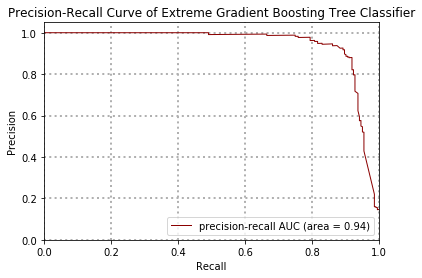

In [51]:
plt.figure(figsize=(12,12))
precision_recall_curve (lg, 'Logistic Regression', 'spam',x_test)
precision_recall_curve (bc, 'Bagging Classifier', 'spam',x_test)
precision_recall_curve (rf, 'Random Forest Classifier', 'spam',x_test)
precision_recall_curve (sgd, 'Stochastic Gradient Descent Classifier with Logistic Regression', 'spam',x_test)
precision_recall_curve (xgb, 'Extreme Gradient Boosting Tree Classifier', 'spam',x_test)

## 5. Learning Curves Comparison

In [52]:
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    from sklearn.model_selection import learning_curve
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    #Learning curve definition
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    # commands for plotting
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="red")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")
    plt.plot(train_sizes, train_scores_mean, '^-', color="red",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '^-', color="green",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

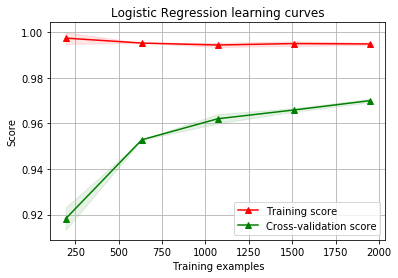

In [53]:
g = plot_learning_curve(lg,"Logistic Regression learning curves", x_train, y_train,cv=2,n_jobs=-1)


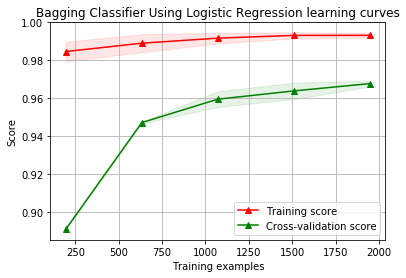

In [54]:
g = plot_learning_curve(bc,"Bagging Classifier Using Logistic Regression learning curves", x_train, y_train,cv=2,n_jobs=-1)


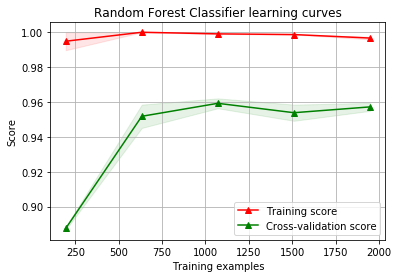

In [55]:
g = plot_learning_curve(rf,"Random Forest Classifier learning curves",x_train,y_train,cv=2,n_jobs=-1)


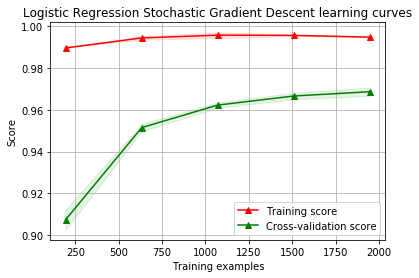

In [56]:
g = plot_learning_curve(sgd,"Logistic Regression Stochastic Gradient Descent learning curves",x_train,y_train,cv=2,n_jobs=-1)


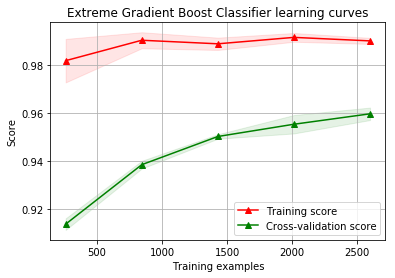

In [57]:
g = plot_learning_curve(xgb,"Extreme Gradient Boost Classifier learning curves",x_train,y_train,cv=3,n_jobs=-1)

## 6. Dimensionality Reduction With Truncated SVD

Text(0, 0.5, 'Cumulative explained variance')

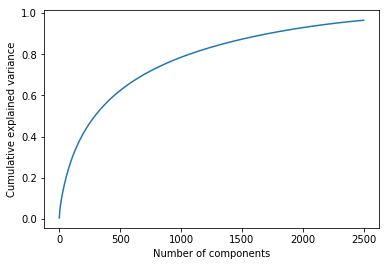

In [58]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2500)
# Let's check how much of the 166 predictor variable's multidimensional variance is retained by the components
z = svd.fit_transform(x)

plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [59]:
print(np.sum(svd.explained_variance_ratio_))

0.9649181772093182


In [60]:
z_train, z_test, y_train, y_test = train_test_split(z, y, test_size=0.3, random_state=42)
print(z_train.shape, z_test.shape, y_train.shape, y_test.shape)

(3900, 2500) (1672, 2500) (3900,) (1672,)


#### 6.1 Logistic Regression On Reduced Dataset

In [61]:
lg2=LogisticRegression(solver='liblinear',class_weight='balanced',penalty='l2',max_iter=20,C=5)
lg2.fit(z_train,y_train)


LogisticRegression(C=5, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
scores_lg2 = cross_validate(lg2, z_train,y_train, cv=skf, return_train_score=True,return_estimator=False,n_jobs=-1)
scores_lg2 = pd.DataFrame(scores_lg2)
scores_lg2

,fit_time,score_time,test_score,train_score
0,2.981712,0.015622,0.967990,0.995511
1,2.917154,0.000000,0.975672,0.995832
2,2.860534,0.017740,0.974359,0.995833
3,2.912618,0.031248,0.976893,0.994873
4,3.004423,0.000000,0.980745,0.995194


In [63]:
print('Mean Test Score of Logistic Regression Model 2: ', scores_lg2 ['test_score'].mean())
print('Mean Train Score of Logistic Regression Model 2: ', scores_lg2 ['train_score'].mean())

Mean Test Score of Logistic Regression Model 2:  0.9751317887245132
Mean Train Score of Logistic Regression Model 2:  0.9954487997495617


In [64]:
y_pred_lg2 = lg2.predict(z_test)
y_pred_lg2

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'lg2_Prediction')]

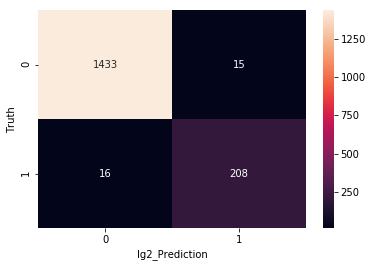

In [65]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_lg2), annot=True, fmt='d')
ax.set(xlabel='lg2_Prediction', ylabel='Truth')

In [66]:
print(classification_report(y_test, y_pred_lg2))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1448
        spam       0.93      0.93      0.93       224

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [67]:
accuracy_score(y_test,y_pred_lg2)

0.9814593301435407

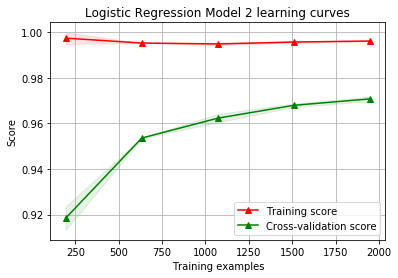

In [68]:
g = plot_learning_curve(lg2,"Logistic Regression Model 2 learning curves",x_train,y_train,cv=2,n_jobs=-1)

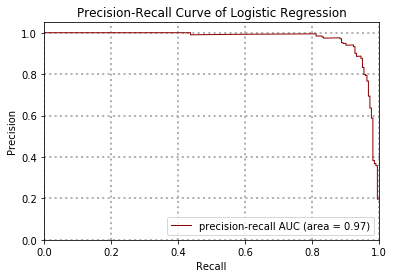

In [69]:
precision_recall_curve (lg2, 'Logistic Regression', 'spam', z_test)

#### 6.2 Logistic Regression On Reduced Dataset


In [70]:
from xgboost import XGBClassifier 

xgb2 = XGBClassifier(gamma=0,n_estimators=10, learning_rate=0.8, max_depth=8, seed=8,reg_lambda=0,n_jobs=-1,booster='gbtree')
xgb2.fit(z_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=10,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
              seed=8, silent=True, subsample=1)

In [71]:
scores_xgb2 = cross_validate(xgb2, z_train,y_train, cv=skf, return_train_score=True,return_estimator=False,n_jobs=-1)
scores_xgb2 = pd.DataFrame(scores_xgb2)
scores_xgb2

,fit_time,score_time,test_score,train_score
0,14.927043,0.223377,0.946223,1.000000
1,15.146427,0.151050,0.959027,0.999679
2,15.303539,0.159169,0.958974,0.999679
3,15.543801,0.042694,0.970475,0.999680
4,10.289222,0.221429,0.955071,0.999680


In [72]:
print('Mean Test Score of Logistic Regression Model 2: ', scores_xgb2 ['test_score'].mean())
print('Mean Train Score of Logistic Regression Model 2: ', scores_xgb2 ['train_score'].mean())

Mean Test Score of Logistic Regression Model 2:  0.9579539220234224
Mean Train Score of Logistic Regression Model 2:  0.99974361026953


In [73]:
y_pred_xgb2 = xgb2.predict(z_test)
y_pred_xgb2

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'xgb2_Prediction')]

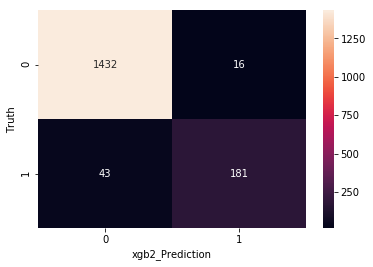

In [74]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred_xgb2), annot=True, fmt='d')
ax.set(xlabel='xgb2_Prediction', ylabel='Truth')

In [75]:
print(classification_report(y_test, y_pred_xgb2))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1448
        spam       0.92      0.81      0.86       224

    accuracy                           0.96      1672
   macro avg       0.94      0.90      0.92      1672
weighted avg       0.96      0.96      0.96      1672



In [76]:
accuracy_score(y_test,y_pred_xgb2)

0.9647129186602871

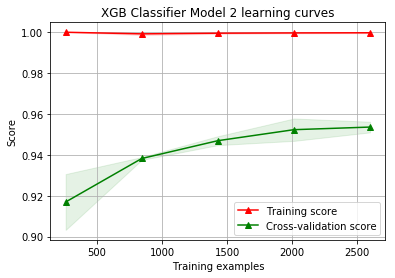

In [77]:
g = plot_learning_curve(xgb2,"XGB Classifier Model 2 learning curves",z_train,y_train,cv=3,n_jobs=-1)

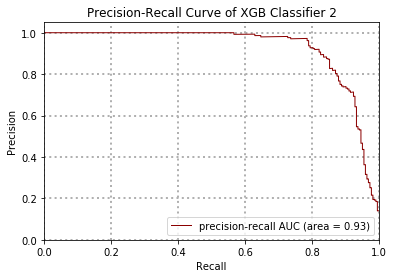

In [78]:
precision_recall_curve (xgb2, 'XGB Classifier 2', 'spam', z_test)